# DEA Coastlines useful tools <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This notebook contains useful code snippets for processing and manipulating DEA Coastlines data.


---

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-coastlines


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [2]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


## Run tests

In [ ]:
pip install -r requirements.in --quiet

In [ ]:
pip install pytest-dependency

In [ ]:
!python -m pytest tests/ -v

## Extract style table from GeoPackage

In [ ]:
import zipfile
with zipfile.ZipFile('../coastlines_v0.2.2.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Load 'layer_styles' from geopackage and export as a CSV
layer = gpd.read_file("coastlines_v0.0.2 (1).gpkg", layer="layer_styles")
layer.drop(['geometry'], axis=1).to_csv('coastlines/styles.csv', index=False)

## View output files on S3

In [ ]:
# !aws s3 --no-sign-request --region=af-south-1 ls --recursive s3://deafrica-data-dev-af/coastlines/ | grep '.gpkg$'

In [ ]:
# !aws s3 --no-sign-request --region=af-south-1 ls --recursive s3://deafrica-data-staging-af/coastlines/


## Run status per tile from Argo YAML

In [3]:
import pandas as pd
import yaml
from yaml import SafeLoader


def retries(x):

    # Get number of successes and total number of rows
    rows_all = len(x.error)
    rows_good = (x.error.isnull()).sum()

    # Summarise by final status and retries
    if rows_all == 1:
        return "succeeded" if rows_good == 1 else "failed"
    elif rows_all == 2:
        return "succeeded after retry" if rows_good == 1 else "failed after retry"


# Load Argo job status
with open("coastlines_v0.0.3_vector.yaml") as f:
    data = yaml.load(f, Loader=SafeLoader)

# Get run params
run_params = {i["name"]: i["value"] for i in data["spec"]["arguments"]["parameters"]}

# Keep only jobs with valid inputs
data_cleaned = {a: b for a, b in data["status"]["nodes"].items() if "inputs" in b}

# Obtain error code or missing error code for each job
df = pd.DataFrame(
    [
        (
            b["inputs"]["parameters"][0]["value"],
            b["type"],
            b["outputs"]["exitCode"],
            b["finishedAt"],
            b["resourcesDuration"]["cpu"],
            b["resourcesDuration"]["memory"],
        )
        if "outputs" in b
        else (b["inputs"]["parameters"][0]["value"], None)
        for a, b in data_cleaned.items()  # if (b["inputs"]["parameters"][0]["value"] == '117')
    ],
    columns=["id", "type", "error", "finishedAt", "duration", "memory"],
)

# Drop non-tiles
df = df.loc[~df.id.isin([run_params["result-version"], run_params["tiles-uri"]])]

# Calculate duration in hours and standardise other cols
df["id"] = df.id.astype(int)
df["finishedAt"] = pd.to_datetime(df["finishedAt"])
df["duration"] = df.duration / 60 / int(run_params['cpu-limit'])

# Set up logical errors
df["error"] = df["error"].replace(
    {None: "pod deleted", "1": "error code 1", "0": None, "137": "memory"}
)

# Drop retries
df_noretry = df.loc[df.type != "Retry"]

# Combine multiple rows per tile with logic to track errors and retries
longest_df = df_noretry.loc[df_noretry.groupby(["id"])["duration"].idxmax()]
retries_df = df_noretry.groupby("id").apply(retries)
tile_status_df = longest_df.merge(retries_df.rename("status"), on="id").drop(
    "type", axis=1
)

In [4]:
tile_status_df.loc[tile_status_df.id == 753]

,id,error,finishedAt,duration,memory,status
752,753,None,2023-01-31 03:06:39+00:00,5.976389,407063,succeeded


In [5]:
tile_status_df.duration.median()

2.6013888888888888

In [6]:
tile_status_df.status.value_counts()

succeeded    648
failed       116
Name: status, dtype: int64

In [7]:
tile_status_df.status.value_counts() / len(tile_status_df.status) * 100

succeeded    84.816754
failed       15.183246
Name: status, dtype: float64

In [8]:
tile_status_df.duration.quantile([0.01, 0.9])

0.01    0.741667
0.90    6.124028
Name: duration, dtype: float64

In [9]:
# Export to geoJSON
# tiles_gdf = gpd.read_file(run_params["tiles-uri"])
tiles_gdf = gpd.read_file('https://data.dea.ga.gov.au/derivative/dea_coastlines/supplementary/albers_grids/ga_summary_grid_c3_48km_coastal_clipped.geojson')
tiles_gdf = tiles_gdf.merge(tile_status_df, on="id")
tiles_gdf.to_file(f"coastlines_tile_status_{run_params['result-version']}.geojson")

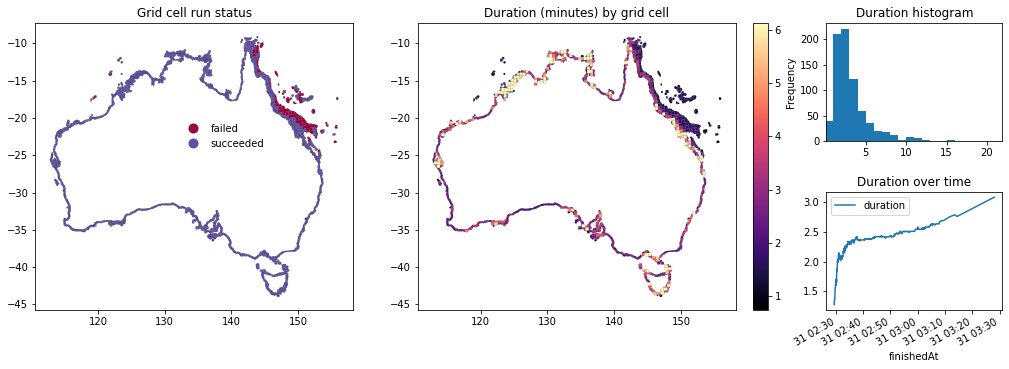

In [18]:
axd = plt.figure(constrained_layout=True, figsize=(14, 5)).subplot_mosaic(
    """
    AABBC
    AABBD
    """
)
axd

axd['A'].set_title('Grid cell run status')
tiles_gdf.plot(column='status', ax=axd['A'], cmap='Spectral', categorical=True, legend=True, edgecolor='black', linewidth=0.1, legend_kwds={'bbox_to_anchor':(0.75, 0.68), 'frameon':False})
axd['B'].set_title('Duration (minutes) by grid cell')
qmin, qmax = tile_status_df.duration.quantile([0.01, 0.9])
tiles_gdf.plot(column='duration', ax=axd['B'], cmap='magma', vmin=qmin, vmax=qmax, legend=True, edgecolor='black', linewidth=0.1)
axd['C'].set_title('Duration histogram')
qmin, qmax = tile_status_df.duration.quantile([0.001, 0.999])
tile_status_df.duration.plot.hist(bins=range(int(qmin), int(qmax),  int(max((qmax - qmin) / 50, 1.0))), xlim=(qmin, qmax), ax=axd['C'])
axd['D'].set_title('Duration over time')
tile_status_df.set_index('finishedAt').sort_index().rolling('30min', min_periods=10).median().plot(y='duration', ax=axd['D'])
plt.gcf().savefig(f"coastlines_tile_status_{run_params['result-version']}.png", dpi=250)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/dea-coastlines/issues/new).

**Last modified:** November 2022

**To cite:**

> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment, 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734
>
> Nanson, R., Bishop-Taylor, R., Sagar, S., Lymburner, L., (2022). Geomorphic insights into Australia's coastal change using a national dataset derived from the multi-decadal Landsat archive. Estuarine, Coastal and Shelf Science, 265, p.107712. Available: https://doi.org/10.1016/j.ecss.2021.107712
>
> Bishop-Taylor, R., Sagar, S., Lymburner, L., Alam, I., Sixsmith, J. (2019). Sub-pixel waterline extraction: characterising accuracy and sensitivity to indices and spectra. Remote Sensing, 11 (24):2984. Available: https://doi.org/10.3390/rs11242984